# GSEAPY Example
Examples to use ``GSEApy`` inside python console

In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

**Check gseapy version**

In [2]:
gp.__version__

'1.0.5'

## Biomart API  

Don't use this if you don't know Biomart

Warning: This API has limited support now

### Convert gene identifiers

In [3]:
from gseapy import Biomart 
bm = Biomart()

In [4]:
## view validated marts
# marts = bm.get_marts()
## view validated dataset
# datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
## view validated attributes
# attrs = bm.get_attributes(dataset='hsapiens_gene_ensembl') 
## view validated filters
# filters = bm.get_filters(dataset='hsapiens_gene_ensembl')
## query results
queries ={'ensembl_gene_id': ['ENSG00000125285','ENSG00000182968'] } # need to be a dict object
results = bm.query(dataset='hsapiens_gene_ensembl', 
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'],
                   filters=queries)
results.tail()

,ensembl_gene_id,external_gene_name,entrezgene_id,go_id
37,ENSG00000182968,SOX1,6656,GO:0021884
38,ENSG00000182968,SOX1,6656,GO:0030900
39,ENSG00000182968,SOX1,6656,GO:0048713
40,ENSG00000182968,SOX1,6656,GO:1904936
41,ENSG00000182968,SOX1,6656,GO:1990830


In [5]:
results.dtypes

ensembl_gene_id       object
external_gene_name    object
entrezgene_id          Int32
go_id                 object
dtype: object

### Mouse gene symbols maps to Human, or Vice Versa

This is useful when you have troubles to convert gene symbols between human and mouse

In [6]:
from gseapy import Biomart 
bm = Biomart()
# note the dataset and attribute names are different
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'mmusculus_homolog_ensembl_gene',
                           'mmusculus_homolog_associated_gene_name'])

In [7]:
# h2m.sample(10)

### Gene Symbols Conversion for the GMT file
This is useful when runing GSEA for non-human species

**e.g. Convert Human gene symbols to Mouse.**

In [8]:
# get a dict symbol mappings
h2m_dict = {}
for i, row in h2m.loc[:,["external_gene_name", "mmusculus_homolog_associated_gene_name"]].iterrows():
    if row.isna().any(): continue
    h2m_dict[row['external_gene_name']] = row["mmusculus_homolog_associated_gene_name"]
# read gmt file into dict
kegg = gp.read_gmt(path="tests/extdata/enrichr.KEGG_2016.gmt")
print(kegg['MAPK signaling pathway Homo sapiens hsa04010'][:10])

['EGF', 'IL1R1', 'IL1R2', 'HSPA1L', 'CACNA2D2', 'CACNA2D1', 'CACNA2D4', 'CACNA2D3', 'MAPK8IP3', 'MAPK8IP1']


In [9]:
kegg_mouse = {}
for term, genes in kegg.items():
    new_genes = []
    for gene in genes:
        if gene in h2m_dict:
            new_genes.append(h2m_dict[gene])
    kegg_mouse[term] = new_genes
print(kegg_mouse['MAPK signaling pathway Homo sapiens hsa04010'][:10])

['Egf', 'Il1r1', 'Il1r2', 'Hspa1l', 'Cacna2d2', 'Cacna2d1', 'Cacna2d4', 'Cacna2d3', 'Mapk8ip3', 'Mapk8ip1']


## Enrichr API

**See all supported enrichr library names**  

Select database from **{ 'Human', 'Mouse', 'Yeast', 'Fly', 'Fish', 'Worm' }**

In [10]:
# default: Human
names = gp.get_library_name()
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']

In [11]:
# yeast
yeast = gp.get_library_name(organism='Yeast') 
yeast[:10]

['Cellular_Component_AutoRIF',
 'Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF']

**Parse Enrichr library into dict**

In [12]:
## download library or read a .gmt file
go_mf = gp.get_library(name='GO_Molecular_Function_2018', organism='Yeast')
print(go_mf['ATP binding (GO:0005524)'])

['MLH1', 'ECM10', 'RLI1', 'SSB1', 'SSB2', 'YTA12', 'MSH2', 'CDC6', 'HMI1', 'YNL247W', 'MSH6', 'SSQ1', 'MCM7', 'SRS2', 'HSP104', 'SSA1', 'MCX1', 'SSC1', 'ARP2', 'ARP3', 'SSE1', 'SMC2', 'SSZ1', 'TDA10', 'ORC5', 'VPS4', 'RBK1', 'SSA4', 'NEW1', 'ORC1', 'SSA2', 'KAR2', 'SSA3', 'DYN1', 'PGK1', 'VPS33', 'LHS1', 'CDC123', 'PMS1']


### Over-representation analysis by Enrichr web services

The only requirement of input is a list of gene symbols.

For online web services, gene symbols are not case sensitive.


- `gene_list` accepts
    - ``pd.Series``
    -  ``pd.DataFrame`` 
    -  ``list`` object
    - ``txt`` file (one gene symbol per row)


- `gene_sets` accepts:

    Multi-libraries names supported, separate each name by comma or input a list. 

For example:
```python
    # gene_list
    gene_list="./data/gene_list.txt", 
    gene_list=glist
    # gene_sets
    gene_sets='KEGG_2016'  
    gene_sets='KEGG_2016,KEGG_2013'
    gene_sets=['KEGG_2016','KEGG_2013']
```

In [13]:
# read in an example gene list
gene_list = pd.read_csv("./tests/data/gene_list.txt",header=None, sep="\t")
gene_list.head()

,0
0,IGKV4-1
1,CD55
2,IGKC
3,PPFIBP1
4,ABHD4


In [14]:
# convert dataframe or series to list
glist = gene_list.squeeze().str.strip().to_list()
print(glist[:10])

['IGKV4-1', 'CD55', 'IGKC', 'PPFIBP1', 'ABHD4', 'PCSK6', 'PGD', 'ARHGDIB', 'ITGB2', 'CARD6']


### Over-representation analysis via Enrichr web services

This is an Example of the Enrichr analysis

**NOTE**: 
1. Enrichr Web Sevices need `gene symbols` as input
2. `Gene symbols` will convert to upcases automatically.
3. (Optional) Input an user defined `background gene list`

#### Enrichr Web Serives (without a backgound input)

In [15]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt", 
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'], 
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk 
                )

In [16]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,IL-6/JAK/STAT3 Signaling,19/87,1.197225e-09,5.986123e-08,0,0,6.844694,140.612324,IL4R;TGFB1;IL1R1;IFNGR1;IL10RB;ITGB3;IFNGR2;IL...
1,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,27/200,3.220898e-08,5.368163e-07,0,0,3.841568,66.270963,BTG2;BCL2A1;PLEK;IRS2;LITAF;IFIH1;PANX1;DRAM1;...
2,MSigDB_Hallmark_2020,Complement,27/200,3.220898e-08,5.368163e-07,0,0,3.841568,66.270963,FCN1;LRP1;PLEK;LIPA;CA2;CASP3;LAMP2;S100A12;FY...
3,MSigDB_Hallmark_2020,Inflammatory Response,24/200,1.635890e-06,2.044862e-05,0,0,3.343018,44.540108,LYN;IFITM1;BTG2;IL4R;CD82;IL1R1;IFNGR2;ITGB3;F...
4,MSigDB_Hallmark_2020,heme Metabolism,23/200,5.533816e-06,5.533816e-05,0,0,3.181358,38.509172,SLC22A4;MPP1;BNIP3L;BTG2;ARHGEF12;NEK7;GDE1;FO...


#### Enrichr Web Service (with `backround` input)

NOTE: Missing `Overlap` column in final output

In [17]:
# backgound only reconigized a gene list input.
enr_bg = gp.enrichr(gene_list=gene_list,
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'], 
                 # organism='human', # organism argment is ignored because user input a background 
                 background="tests/data/background.txt",
                 outdir=None, # don't write to disk 
                )

In [18]:
enr_bg.results.head() # 

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,IL-6/JAK/STAT3 Signaling,3.559435e-11,1.779718e-09,0,0,8.533251,205.300064,IL4R;TGFB1;IL1R1;IFNGR1;IL10RB;ITGB3;IFNGR2;IL...
1,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,3.401526e-10,6.356588e-09,0,0,4.824842,105.189414,BTG2;BCL2A1;PLEK;IRS2;LITAF;IFIH1;PANX1;DRAM1;...
2,MSigDB_Hallmark_2020,Complement,3.813953e-10,6.356588e-09,0,0,4.796735,104.027683,FCN1;LRP1;PLEK;LIPA;CA2;CASP3;LAMP2;S100A12;FY...
3,MSigDB_Hallmark_2020,Inflammatory Response,3.380686e-08,4.225857e-07,0,0,4.197067,72.200480,LYN;IFITM1;BTG2;IL4R;CD82;IL1R1;IFNGR2;ITGB3;F...
4,MSigDB_Hallmark_2020,heme Metabolism,8.943634e-08,8.943634e-07,0,0,4.111306,66.725423,SLC22A4;MPP1;BNIP3L;BTG2;ARHGEF12;NEK7;GDE1;FO...


### Over-representation analysis (hypergeometric test) by offline

This API **DO NOT** use Enrichr web services.


**NOTE**:
1. The input gene symbols are **case sensitive**.
2. You need to **match the type of the gene identifers** which used in your gene_list input and GMT file. 
3. Input a .gmt file or gene_set dict object for the argument `gene_sets`

For example:
```python
    gene_sets="./data/genes.gmt",
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```

In [19]:
# NOTE: `enrich` instead of `enrichr`
enr2 = gp.enrich(gene_list="./tests/data/gene_list.txt", # or gene_list=glist
                 gene_sets=["./tests/data/genes.gmt", "unknown", kegg ], # kegg is a dict object
                 background=None, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                 outdir=None, 
                 verbose=True)

2023-06-14 17:26:02,491 [INFO] User defined gene sets is given: ./tests/data/genes.gmt
2023-06-14 17:26:02,510 [INFO] Input dict object named with gs_ind_2
2023-06-14 17:26:03,090 [WARNING] Input library not found: unknown. Skip
2023-06-14 17:26:03,098 [INFO] Run: genes.gmt 
2023-06-14 17:26:03,110 [INFO] Background is not set! Use all 682 genes in genes.gmt.
2023-06-14 17:26:03,130 [INFO] Run: gs_ind_2 
2023-06-14 17:26:03,477 [INFO] Background is not set! Use all 7010 genes in gs_ind_2.
2023-06-14 17:26:04,880 [INFO] Done.


In [20]:
enr2.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,genes.gmt,BvA_UpIN_A,8/139,0.457390,0.568432,1.161982,0.908925,PCSK6;MAP3K5;HAL;PADI2;MBOAT2;IL1R1;MSRB2;IQGAP2
1,genes.gmt,BvA_UpIN_B,12/130,0.026744,0.187208,2.160059,7.822534,ST3GAL6;ARHGDIB;SYK;IL1RAP;HEBP1;KCTD12;MBNL3;...
2,genes.gmt,CvA_UpIN_A,1/12,0.481190,0.568432,2.266479,1.657913,MBOAT2
3,genes.gmt,DvA_UpIN_A,16/284,0.426669,0.568432,1.127395,0.960255,PCSK6;MAP3K5;KIF1B;PADI2;HAL;IQGAP2;ANXA11;MBO...
4,genes.gmt,DvA_UpIN_D,13/236,0.487227,0.568432,1.084567,0.779830,ST3GAL6;GLIPR2;GNB4;SIRPA;HEBP1;IL1RAP;MBNL3;F...


#### About Background genes 

By default, all genes in the `gene_sets` input will be used as background. 

However, a better background genes would be the following:


1. (Recommended) Input a list of background genes: ['gene1', 'gene2',...]
    - The background gene list is defined by your experment. e.g. the expressed genes in your RNA-seq.
    - The gene identifer in gmt/dict should be the same type to the backgound genes.

2. Specify a number: e.g. 20000. (the number of total expressed genes).
    - This works, but not recommend. It assumes that all your genes could be found in background.
    - If genes exist in gmt but not included in background provided, they will affect the significance of the statistical test.

3. Set a Biomart dataset name: e.g. "hsapiens_gene_ensembl"
    - The background will use all annotated genes from the `BioMart datasets` you've choosen.
    - The program will try to retrieve the background information automatically.


### Plotting

Show top 5 terms of each gene_set ranked by "Adjusted P-value"

In [21]:
# simple plotting function
from gseapy import barplot, dotplot

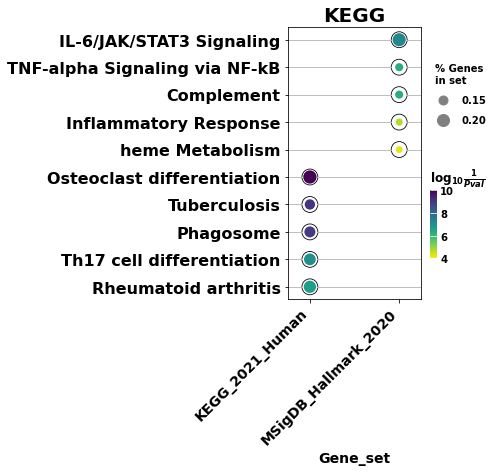

In [22]:
# categorical scatterplot
ax = dotplot(enr.results, 
              column="Adjusted P-value", 
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10, 
              top_term=5,
              figsize=(3,5), 
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

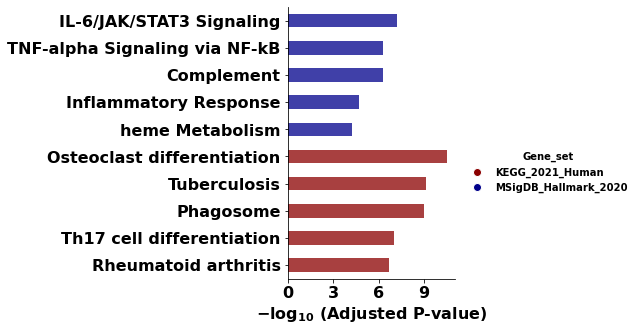

In [23]:
# categorical scatterplot
ax = barplot(enr.results, 
              column="Adjusted P-value", 
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10, 
              top_term=5,
              figsize=(3,5), 
              color=['darkred', 'darkblue'] # set colors for group
             )

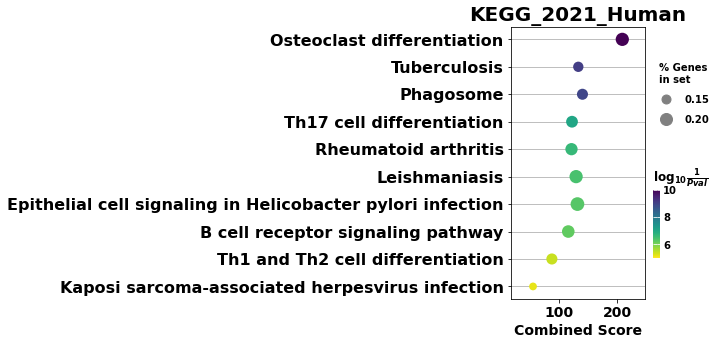

In [24]:
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(enr.res2d, title='KEGG_2021_Human',cmap='viridis_r', size=10, figsize=(3,5))

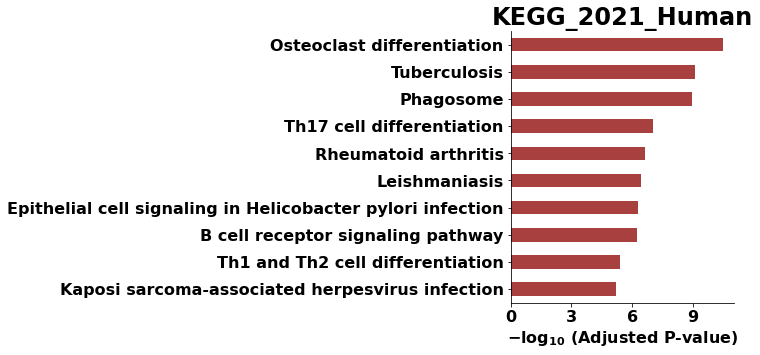

In [25]:
# to save your figure, make sure that ``ofname`` is not None
ax = barplot(enr.res2d,title='KEGG_2021_Human', figsize=(4, 5), color='darkred')

### Command line usage 

the option **-v** will print out the progress of your job

In [26]:
# !gseapy enrichr -i ./data/gene_list.txt \
#                 -g GO_Biological_Process_2017 \
#                 -v -o test/enrichr_BP

## Prerank example

### Assign prerank() with 

- pd.DataFrame: Only contains two columns, or one cloumn with gene_name indexed 
- pd.Series 
- a txt file: 
  - **GSEApy will skip any data after "#".** 
  - Do not include header in your gene list !  


#### NOTE: UPCASES for gene symbols by Default

1. Gene symbols are all "UPCASES" in the Enrichr Libaries. You should convert your input gene identifier to "UPCASES" first.
2. If input `gmt`, `dict` object, please refer to `1.2 Mouse gene symbols maps to Human, or Vice Versa` (in this page) to convert gene identifier



#### Supported gene_sets input
For example:
```python
    gene_sets="KEGG_2016",
    gene_sets="KEGG_2016,KEGG2013",
    gene_sets="./data/genes.gmt",
    gene_sets=["KEGG_2016","./data/genes.gmt"],
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```

In [27]:
rnk = pd.read_csv("./tests/data/temp.rnk", header=None, index_col=0, sep="\t")
rnk.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [28]:
rnk.shape

(22922, 1)

In [29]:
# # run prerank
# # enrichr libraries are supported by prerank module. Just provide the name
# # use 4 process to acceralate the permutation speed
pre_res = gp.prerank(rnk="./tests/data/temp.rnk", # or rnk = rnk,
                     gene_sets='KEGG_2016', 
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk 
                     seed=6, 
                     verbose=True, # see what's going on behind the scenes
                    )

2023-06-14 17:26:11,792 [WARNING] Duplicated values found in preranked stats: 4.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-06-14 17:26:11,794 [INFO] Parsing data files for GSEA.............................
2023-06-14 17:26:11,796 [INFO] Enrichr library gene sets already downloaded in: /home/fangzq/.cache/gseapy, use local file
2023-06-14 17:26:11,830 [INFO] 0001 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-06-14 17:26:11,832 [INFO] 0292 gene_sets used for further statistical testing.....
2023-06-14 17:26:11,833 [INFO] Start to run GSEA...Might take a while..................
2023-06-14 17:26:25,627 [INFO] Congratulations. GSEApy runs successfully................



### How to generate your GSEA plot inside python console  
Visualize it using ``gseaplot``  

Make sure that ``ofname`` is not None, if you want to save your figure to the disk

In [30]:
pre_res.res2d.head(5)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Adherens junction Homo sapiens hsa04520,0.784625,1.912548,0.0,0.0,0.0,47/74,10.37%,CTNNB1;EGFR;RAC1;TGFBR1;SMAD4;MET;EP300;CDC42;...
1,prerank,Glioma Homo sapiens hsa05214,0.784678,1.906706,0.0,0.0,0.0,52/65,16.29%,CALM1;GRB2;EGFR;PRKCA;KRAS;HRAS;TP53;MAPK1;PRK...
2,prerank,Estrogen signaling pathway Homo sapiens hsa04915,0.766347,1.897957,0.0,0.0,0.0,74/99,16.57%,CALM1;PRKACA;GRB2;SP1;EGFR;KRAS;HRAS;HSP90AB1;...
3,prerank,Thyroid hormone signaling pathway Homo sapiens...,0.7577,1.891815,0.0,0.0,0.0,84/118,16.29%,CTNNB1;PRKACA;PRKCA;KRAS;NOTCH1;EP300;CREBBP;H...
4,prerank,Long-term potentiation Homo sapiens hsa04720,0.778249,1.888739,0.0,0.0,0.0,42/66,9.01%,CALM1;PRKACA;PRKCA;KRAS;EP300;CREBBP;HRAS;PRKA...


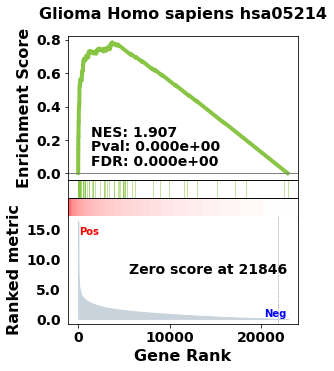

In [31]:
## easy way
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[1]) # v1.0.5
# to make more control on the plot, use
# from gseapy import gseaplot
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

or multi pathway in one

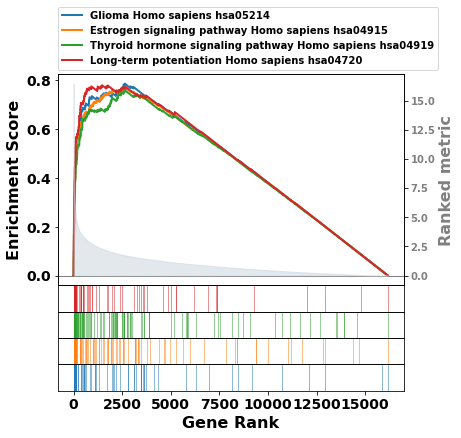

In [32]:
axs = pre_res.plot(terms=terms[1:5], 
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )
# or use this to have more control on the plot
# from gseapy import gseaplot2
# terms = pre_res.res2d.Term[1:5]
# hits = [pre_res.results[t]['hits'] for t in terms]
# runes = [pre_res.results[t]['RES'] for t in terms]
# fig = gseaplot2(terms=terms, ress=runes, hits=hits, 
#               rank_metric=gs_res.ranking, 
#               legend_kws={'loc': (1.2, 0)}, # set the legend loc
#               figsize=(4,5)) # rank_metric=pre_res.ranking 

`dotplot` for GSEA resutls

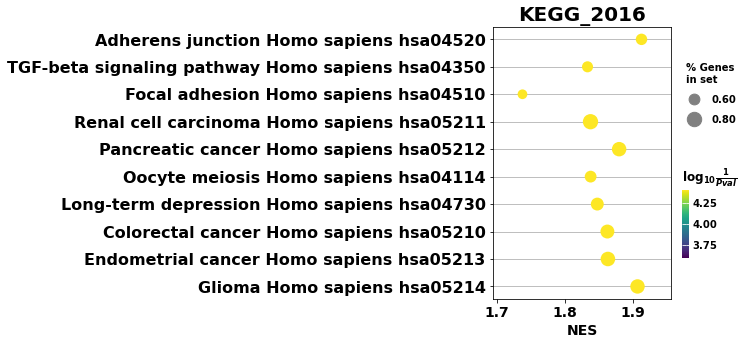

In [33]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(pre_res.res2d, 
             column="FDR q-val",
             title='KEGG_2016',
             cmap=plt.cm.viridis, 
             size=3, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

Network Visualization

- use `enrichment_map` to build network
- save the `nodes` and `edges`. They could be used for `cytoscape` visualization.


In [34]:
from gseapy import enrichment_map
# return two dataframe
nodes, edges = enrichment_map(pre_res.res2d)

In [35]:
import networkx as nx

In [36]:
# build graph
G = nx.from_pandas_edgelist(edges, 
                            source='src_idx', 
                            target='targ_idx', 
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

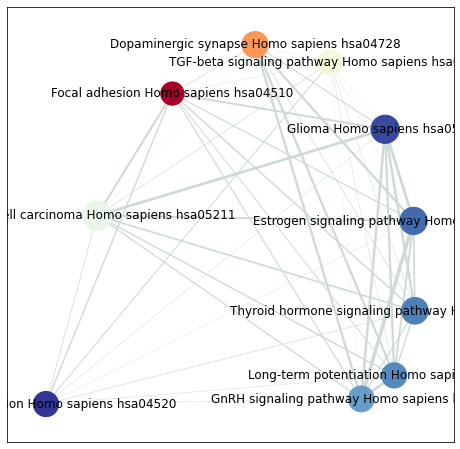

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))

# init node cooridnates
pos=nx.layout.spiral_layout(G)
#node_size = nx.get_node_attributes()
# draw node
nx.draw_networkx_nodes(G, 
                       pos=pos, 
                       cmap=plt.cm.RdYlBu, 
                       node_color=list(nodes.NES),
                       node_size=list(nodes.Hits_ratio *1000))
# draw node label
nx.draw_networkx_labels(G, 
                        pos=pos, 
                        labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G, 
                       pos=pos, 
                       width=list(map(lambda x: x*10, edge_weight)), 
                       edge_color='#CDDBD4')
plt.show()

### Command line usage 

You may also want to use prerank in command line

In [38]:
# !gseapy prerank -r temp.rnk -g temp.gmt -o prerank_report_temp

## GSEA Example


### Inputs 

Assign gsea() 

- data with: 
  - pandas DataFrame
  - .gct format file, or a text file

- cls with: 
  - a list
  - a .cls format file 

- gene_sets with:

```python
    gene_sets="KEGG_2016",
    gene_sets="KEGG_2016,KEGG2013",
    gene_sets="./data/genes.gmt",
    gene_sets=["KEGG_2016","./data/genes.gmt"],
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```


#### NOTE: UPCASES for gene symbols by Default

1. Gene symbols are all "UPCASES" in the Enrichr Libaries. You should convert your input gene identifier to "UPCASES" first.
2. If input `gmt`, `dict` object, please refer to `1.2 Mouse gene symbols maps to Human, or Vice Versa` (in this page) to convert gene identifier


In [39]:
import gseapy as gp
phenoA, phenoB, class_vector =  gp.parser.gsea_cls_parser("./tests/extdata/Leukemia.cls")

In [40]:
#class_vector used to indicate group attributes for each sample
print(class_vector)

['ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML']


In [41]:
gene_exp = pd.read_csv("./tests/extdata/Leukemia_hgu95av2.trim.txt", sep="\t")
gene_exp.head()

,Gene,NAME,ALL_1,ALL_2,ALL_3,ALL_4,ALL_5,ALL_6,ALL_7,ALL_8,...,AML_15,AML_16,AML_17,AML_18,AML_19,AML_20,AML_21,AML_22,AML_23,AML_24
0,MAPK3,1000_at,1633.6,2455.0,866.0,1000.0,3159.0,1998.0,1580.0,1955.0,...,1826.0,2849.0,2980.0,1442.0,3672.0,294.0,2188.0,1245.0,1934.0,13154.0
1,TIE1,1001_at,284.4,159.0,173.0,216.0,1187.0,647.0,352.0,1224.0,...,1556.0,893.0,1278.0,301.0,797.0,248.0,167.0,941.0,1398.0,-502.0
2,CYP2C19,1002_f_at,285.8,114.0,429.0,-43.0,18.0,366.0,119.0,-88.0,...,-177.0,64.0,-359.0,68.0,2.0,-464.0,-127.0,-279.0,301.0,509.0
3,CXCR5,1003_s_at,-126.6,-388.0,143.0,-915.0,-439.0,-371.0,-448.0,-862.0,...,237.0,-834.0,-1940.0,-684.0,-1236.0,-1561.0,-895.0,-1016.0,-2238.0,-1362.0
4,CXCR5,1004_at,-83.3,33.0,195.0,85.0,54.0,-6.0,55.0,101.0,...,86.0,-5.0,487.0,102.0,33.0,-153.0,-50.0,257.0,439.0,386.0


In [42]:
print("positively correlated: ", phenoA)

positively correlated:  ALL


In [43]:
print("negtively correlated: ", phenoB)

negtively correlated:  AML


In [44]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name
gs_res = gp.gsea(data=gene_exp, # or data='./P53_resampling_data.txt'
                 gene_sets='./tests/extdata/h.all.v7.0.symbols.gmt', # or enrichr library names
                 cls= "./tests/extdata/Leukemia.cls", # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype', 
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 7)

2023-06-14 17:26:33,570 [WARNING] Dropping duplicated gene names, only keep the first values


In [45]:
#access the dataframe results throught res2d attribute
gs_res.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,HALLMARK_E2F_TARGETS,0.574187,1.661335,0.052521,0.577605,0.259,87/151,23.65%,DCK;BARD1;NASP;SRSF2;STMN1;SRSF1;TRA2B;EZH2;SM...
1,gsea,HALLMARK_MITOTIC_SPINDLE,0.430183,1.646924,0.026804,0.31929,0.279,84/147,37.31%,SPTAN1;SEPT9;ATG4B;SMC1A;MYH10;BIN1;CYTH2;TUBG...
2,gsea,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.438876,1.586567,0.013834,0.293792,0.353,11/30,22.99%,LEF1;SKP2;HDAC2;GNAI1;CUL1;MAML1;WNT1;HDAC5;AX...
3,gsea,HALLMARK_TNFA_SIGNALING_VIA_NFKB,-0.49294,-1.521229,0.111562,1.0,0.466934,104/177,28.92%,MCL1;CEBPB;PLAU;IL18;PLEK;BCL3;CEBPD;PLAUR;JUN...
4,gsea,HALLMARK_MYC_TARGETS_V1,0.535105,1.519305,0.156448,0.341741,0.481,115/174,33.61%,HNRNPA3;HDDC2;RFC4;SRSF2;SRSF1;TRA2B;RRM1;HNRN...


### Show the gsea plots

The **gsea** module will generate heatmap for genes in each gene sets in the backgroud.  
But if you need to do it yourself, use the code below

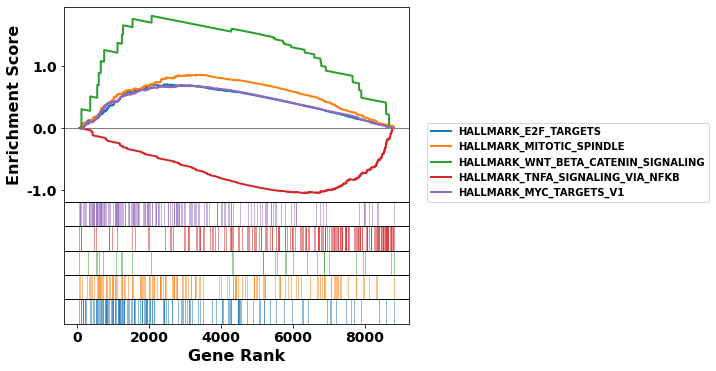

In [46]:
terms = gs_res.res2d.Term
axs = gs_res.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )

In [47]:
# or use 
# from gseapy import gseaplot2

# # multi in one
# terms = gs_res.res2d.Term[:5]
# hits = [gs_res.results[t]['hits'] for t in terms]
# runes = [gs_res.results[t]['RES'] for t in terms]
# fig = gseaplot2(terms=terms, ress=runes, hits=hits, 
#               rank_metric=gs_res.ranking, 
#               legend_kws={'loc': (1.2, 0)}, # set the legend loc
#               figsize=(4,5)) # rank_metric=pre_res.ranking 

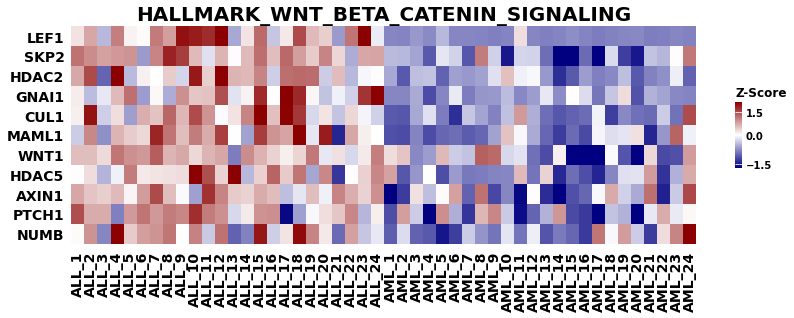

In [48]:
from gseapy import heatmap
# plotting heatmap
i = 2
genes = gs_res.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
ax = heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4))

In [49]:
gs_res.heatmat.loc[genes]

,ALL_1,ALL_2,ALL_3,ALL_4,ALL_5,ALL_6,ALL_7,ALL_8,ALL_9,ALL_10,...,AML_15,AML_16,AML_17,AML_18,AML_19,AML_20,AML_21,AML_22,AML_23,AML_24
Gene,,,,,,,,,,,,,,,,,,,,,
LEF1,8544.1,12552.0,2869.0,15265.0,7446.0,6991.0,15520.0,13114.0,22604.0,21795.0,...,682.0,152.0,-348.0,30.0,210.0,350.0,-242.0,-47.0,176.0,14.0
SKP2,23.8,-45.0,-95.0,-71.0,-65.0,-547.0,-24.0,230.0,159.0,-162.0,...,-865.0,-642.0,-1005.0,-413.0,-733.0,-812.0,-464.0,-490.0,-333.0,7.0
HDAC2,4542.9,6030.0,1195.0,9368.0,2281.0,3407.0,3175.0,3962.0,2616.0,6848.0,...,1072.0,1918.0,1545.0,1653.0,2328.0,1061.0,1571.0,1749.0,2942.0,1174.0
GNAI1,588.5,163.0,364.0,882.0,1317.0,17.0,518.0,89.0,1136.0,816.0,...,470.0,313.0,-163.0,210.0,684.0,-331.0,115.0,55.0,-80.0,-94.0
CUL1,2333.1,4421.0,1794.0,2472.0,1429.0,2941.0,2748.0,3614.0,2856.0,3876.0,...,984.0,1061.0,2063.0,712.0,1271.0,1087.0,1049.0,1786.0,1106.0,3877.0
MAML1,871.4,1871.0,578.0,1589.0,1448.0,1364.0,2494.0,1989.0,1538.0,1946.0,...,390.0,233.0,1075.0,962.0,997.0,1316.0,48.0,609.0,2090.0,1056.0
WNT1,-872.5,-875.0,-1012.0,-535.0,-654.0,-694.0,-421.0,-827.0,-770.0,-1001.0,...,-2506.0,-2791.0,-2249.0,-1201.0,-1819.0,-2599.0,-995.0,-1861.0,-1835.0,-714.0
HDAC5,2137.2,2374.0,1651.0,2012.0,3132.0,2279.0,2314.0,2349.0,2376.0,5455.0,...,1215.0,1024.0,760.0,1368.0,1923.0,1927.0,2872.0,848.0,1629.0,2763.0
AXIN1,-433.5,-722.0,-808.0,-623.0,-1167.0,-326.0,448.0,-661.0,-1315.0,-1991.0,...,-2590.0,-2417.0,-1321.0,-466.0,-1628.0,-1910.0,93.0,-2951.0,-1666.0,471.0


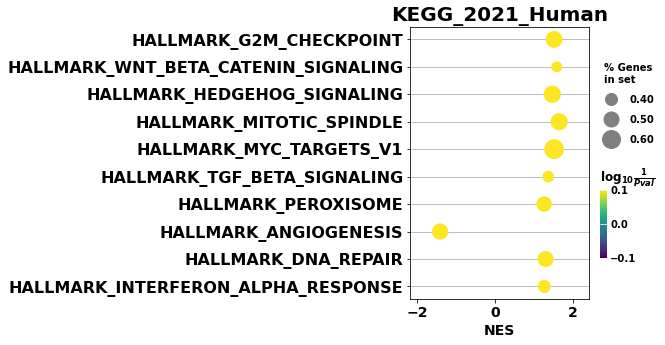

In [50]:
from gseapy import dotplot, ringplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(gs_res.res2d, 
             column="FDR q-val",
             title='KEGG_2021_Human',
             cmap=plt.cm.viridis, 
             size=5, 
             figsize=(4,5), cutoff=1)

### Command line usage 

You may also want to use gsea in command line

In [51]:
# !gseapy gsea -d ./data/P53_resampling_data.txt \
#              -g KEGG_2016 -c ./data/P53.cls \
#              -o test/gsea_reprot_2 \
#              -v --no-plot \
#              -t phenotype

## Single Sample GSEA example


What's ssGSEA? Which one should I use? Prerank or ssGSEA

see FAQ [here](https://github.com/zqfang/GSEApy/wiki/FAQ)


#### Input format  
Assign 
- `data` with 
  - a txt file, gct file, 
  - pd.DataFrame
  - pd.Seires(gene name as index)
  
- gene_sets with:

```python
    gene_sets="KEGG_2016",
    gene_sets="KEGG_2016,KEGG2013",
    gene_sets="./data/genes.gmt",
    gene_sets=["KEGG_2016","./data/genes.gmt"],
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```


#### NOTE: UPCASES for gene symbols by Default

1. Gene symbols are all "UPCASES" in the Enrichr Libaries. You should convert your input gene identifier to "UPCASES" first.
2. If input `gmt`, `dict` object, please refer to `1.2 Mouse gene symbols maps to Human, or Vice Versa` (in this page) to convert gene identifier


In [52]:
import gseapy as gp
# txt, gct file input
ss = gp.ssgsea(data='./tests/extdata/Leukemia_hgu95av2.trim.txt',
               gene_sets='./tests/extdata/h.all.v7.0.symbols.gmt',
               outdir=None, 
               sample_norm_method='rank', # choose 'custom' will only use the raw value of `data`
               no_plot=True)

2023-06-14 17:26:50,950 [WARNING] Dropping duplicated gene names, values averaged by gene names!


In [53]:
ss.res2d.head()

,Name,Term,ES,NES
0,ALL_2,HALLMARK_MYC_TARGETS_V1,3393.823575,0.707975
1,ALL_12,HALLMARK_MYC_TARGETS_V1,3385.626111,0.706265
2,AML_11,HALLMARK_MYC_TARGETS_V1,3359.186716,0.700749
3,ALL_14,HALLMARK_MYC_TARGETS_V1,3348.938881,0.698611
4,ALL_17,HALLMARK_MYC_TARGETS_V1,3335.065348,0.695717


In [54]:
# or assign a dataframe, or Series to ssgsea()
ssdf = pd.read_csv("./tests/data/temp.rnk", header=None,index_col=0,  sep="\t")
ssdf.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [55]:
# dataframe with one column is also supported by ssGSEA or Prerank
# But you have to set gene_names as index
ssdf2 = ssdf.squeeze()

In [56]:
# Series, DataFrame Example
# supports dataframe and series
temp  = gp.ssgsea(data=ssdf2, gene_sets="./tests/data/temp.gmt")

### Access Enrichment Score (ES) and NES

Results are saved to obj.res2d

In [57]:
# NES and ES
ss.res2d.sort_values('Name').head()

,Name,Term,ES,NES
601,ALL_1,HALLMARK_PANCREAS_BETA_CELLS,-1280.654659,-0.267153
934,ALL_1,HALLMARK_APOPTOSIS,970.822693,0.20252
1774,ALL_1,HALLMARK_HEDGEHOG_SIGNALING,431.41465,0.089996
279,ALL_1,HALLMARK_INTERFERON_ALPHA_RESPONSE,1721.458034,0.359108
1778,ALL_1,HALLMARK_BILE_ACID_METABOLISM,-429.137781,-0.089521


In [58]:
nes = ss.res2d.pivot(index='Term', columns='Name', values='NES')
nes.head()

Name,ALL_1,ALL_10,ALL_11,ALL_12,ALL_13,ALL_14,ALL_15,ALL_16,ALL_17,ALL_18,...,AML_22,AML_23,AML_24,AML_3,AML_4,AML_5,AML_6,AML_7,AML_8,AML_9
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_ADIPOGENESIS,0.287381,0.274548,0.290059,0.285388,0.322757,0.305239,0.275686,0.266209,0.315803,0.282617,...,0.277755,0.261477,0.200083,0.312948,0.342963,0.253282,0.298924,0.410395,0.387433,0.343606
HALLMARK_ALLOGRAFT_REJECTION,0.061771,0.028062,0.096589,0.080713,0.082701,0.102735,0.12525,0.147262,0.124621,0.091077,...,0.185738,0.157852,0.055585,0.218827,0.172395,0.199077,0.158945,0.13835,0.110787,0.121643
HALLMARK_ANDROGEN_RESPONSE,0.133453,0.113911,0.193074,0.201531,0.151001,0.12967,0.173563,0.144836,0.180214,0.180801,...,0.180443,0.188891,0.197979,0.174892,0.14285,0.184843,0.157449,0.162843,0.180475,0.181878
HALLMARK_ANGIOGENESIS,-0.113481,-0.182411,-0.195637,-0.094817,-0.163717,-0.139243,-0.119084,-0.154526,-0.06829,-0.121156,...,0.054883,-0.023782,0.119022,-0.067741,0.04843,0.012808,0.032505,-0.024058,-0.039492,-0.043769
HALLMARK_APICAL_JUNCTION,0.051372,0.063763,0.054601,0.014385,0.049019,0.05269,0.064787,0.052192,0.05607,0.064936,...,0.10927,0.090065,0.155801,0.091556,0.110045,0.101659,0.128808,0.095511,0.080076,0.098644


**Warning !!!**

if you set permutation_num > 0, ssgsea will become `prerank` with ssGSEA statistics. **DO NOT** use this, unless you known what you are doing !

```python
ss_permut = gp.ssgsea(data="./tests/extdata/Leukemia_hgu95av2.trim.txt",
               gene_sets="./tests/extdata/h.all.v7.0.symbols.gmt", 
               outdir=None, 
               sample_norm_method='rank', # choose 'custom' for your custom metric
               permutation_num=20, # set permutation_num > 0, it will act like prerank tool
               no_plot=True, # skip plotting, because you don't need these figures
               processes=4, seed=9)
ss_permut.res2d.head(5)
```

### Command line usage of ssGSEA

In [59]:
# !gseapy ssgsea -d ./data/testSet_rand1200.gct \
#                -g data/temp.gmt \
#                -o test/ssgsea_report2  \
#                -p 4 --no-plot 

## Replot Example

### Locate your directory

Notes: ``replot`` module need to find edb folder to work properly.
keep the file tree like this:
```
data
 |--- edb
 |    |--- C1OE.cls
 |    |--- gene_sets.gmt
 |    |--- gsea_data.gsea_data.rnk
 |    |--- results.edb

```

In [60]:
# run command inside python console
rep = gp.replot(indir="./tests/data", outdir="test/replot_test")

### Command line usage of replot

In [61]:
# !gseapy replot -i data -o test/replot_test